## Imports

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import pickle


## Reading csv files

In [ ]:
!wget --header="Host: doc-00-4k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Cookie: AUTH_mm5pe75pf4mhpbdikb2k80b74s62g311=08255761277798433337|1644822375000|8njvl3bb31pcddafp9vqk6006d23qkta" --header="Connection: keep-alive" "https://doc-00-4k-docs.googleusercontent.com/docs/securesc/lo66ka9s3k9ovif7kku17kum7962ok4j/d89h7h67gectsec5r7lqj50dmgv3mvvv/1644822450000/08255761277798433337/08255761277798433337/1kuXib6Vqrh2YnCl1lOegUmxK6bDmgCvu?e=download&authuser=0" -c -O 'spam.csv'

--2022-02-14 07:08:41--  https://doc-00-4k-docs.googleusercontent.com/docs/securesc/lo66ka9s3k9ovif7kku17kum7962ok4j/d89h7h67gectsec5r7lqj50dmgv3mvvv/1644822450000/08255761277798433337/08255761277798433337/1kuXib6Vqrh2YnCl1lOegUmxK6bDmgCvu?e=download&authuser=0
Resolving doc-00-4k-docs.googleusercontent.com (doc-00-4k-docs.googleusercontent.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to doc-00-4k-docs.googleusercontent.com (doc-00-4k-docs.googleusercontent.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.008s  

2022-02-14 07:08:41 (56.7 MB/s) - ‘spam.csv’ saved [503663/503663]



In [39]:
sms_spam_data = pd.read_csv("spam.csv", encoding = "ISO-8859-1")


In [40]:
print('sms_spam_data', sms_spam_data.shape)

sms_spam_data (5572, 5)


In [41]:
sms_spam_data = sms_spam_data[['v1','v2']]
print(sms_spam_data.shape)
sms_spam_data.head()

(5572, 2)


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
sms_spam_data.rename(columns = {'v1':'y'}, inplace = True)
sms_spam_data.rename(columns = {'v2':'text'}, inplace = True)



In [43]:
sms_spam_data.head()

,y,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data preprocessing

### Decontractions

In [44]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

sms_spam_data['clean_msg']= sms_spam_data['text'].apply(lambda x: decontractions(x))
sms_spam_data.head()

,y,text,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I do not think he goes to usf, he lives ar..."


### Punctuation removal

In [45]:
import string
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuation_free="".join([i for i in text if i not in string.punctuation])
    return punctuation_free
#storing the puntuation free text
sms_spam_data['clean_msg']= sms_spam_data['clean_msg'].apply(lambda x:remove_punctuation(x))
sms_spam_data.head()

,y,text,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only in ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I do not think he goes to usf he lives aro...


### Converting to lowercase

In [46]:
sms_spam_data['clean_msg']= sms_spam_data['clean_msg'].apply(lambda x: x.lower())
print(sms_spam_data.head())


      y  ...                                          clean_msg
0   ham  ...  go until jurong point crazy available only in ...
1   ham  ...                            ok lar joking wif u oni
2  spam  ...  free entry in 2 a wkly comp to win fa cup fina...
3   ham  ...        u dun say so early hor u c already then say
4   ham  ...  nah i do not think he goes to usf he lives aro...

[5 rows x 3 columns]


### Tokenization

In [47]:
#defining function for tokenization
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

 
def tokenization(text):
    # tokens = re.split('W+',text)
    tokens = word_tokenize(text)
    return tokens
#applying function to the column
sms_spam_data['clean_msg']= sms_spam_data['clean_msg'].apply(lambda x: tokenization(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
print(sms_spam_data.head())


      y  ...                                          clean_msg
0   ham  ...  [go, until, jurong, point, crazy, available, o...
1   ham  ...                     [ok, lar, joking, wif, u, oni]
2  spam  ...  [free, entry, in, 2, a, wkly, comp, to, win, f...
3   ham  ...  [u, dun, say, so, early, hor, u, c, already, t...
4   ham  ...  [nah, i, do, not, think, he, goes, to, usf, he...

[5 rows x 3 columns]


### Stopwords removal

In [49]:
#importing nlp library
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    
    output= [i for i in text if i not in stopwords]
    # print(output)
    return output
#applying the function
sms_spam_data['clean_msg']= sms_spam_data['clean_msg'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
print(sms_spam_data.head())


      y  ...                                          clean_msg
0   ham  ...  [go, jurong, point, crazy, available, bugis, n...
1   ham  ...                     [ok, lar, joking, wif, u, oni]
2  spam  ...  [free, entry, 2, wkly, comp, win, fa, cup, fin...
3   ham  ...      [u, dun, say, early, hor, u, c, already, say]
4   ham  ...     [nah, think, goes, usf, lives, around, though]

[5 rows x 3 columns]


### Lemmatization

In [51]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text
sms_spam_data['clean_msg']=sms_spam_data['clean_msg'].apply(lambda x:lemmatizer(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
print(sms_spam_data.head())


      y  ...                                          clean_msg
0   ham  ...  [go, jurong, point, crazy, available, bugis, n...
1   ham  ...                     [ok, lar, joking, wif, u, oni]
2  spam  ...  [free, entry, 2, wkly, comp, win, fa, cup, fin...
3   ham  ...      [u, dun, say, early, hor, u, c, already, say]
4   ham  ...        [nah, think, go, usf, life, around, though]

[5 rows x 3 columns]


### Modifying class column to integer

In [53]:
sms_spam_data['y'] = sms_spam_data['y'].map(dict(spam=1, ham=0))

sms_spam_data.head()

,y,text,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, life, around, though]"


## Exploratory Data Analysis

### Class Distribution

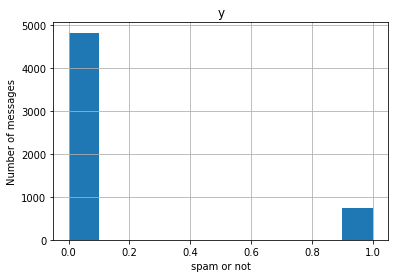

In [ ]:
sms_spam_data.hist(column='y');
plt.xlabel("spam or not")
plt.ylabel("Number of messages")
plt.show()

1. There are approximately 4000 messages are not spam and almost 750 messages are spam
2. The data is extremely imbalanced

### Univariate analysis

#### Wordcloud for not spam text

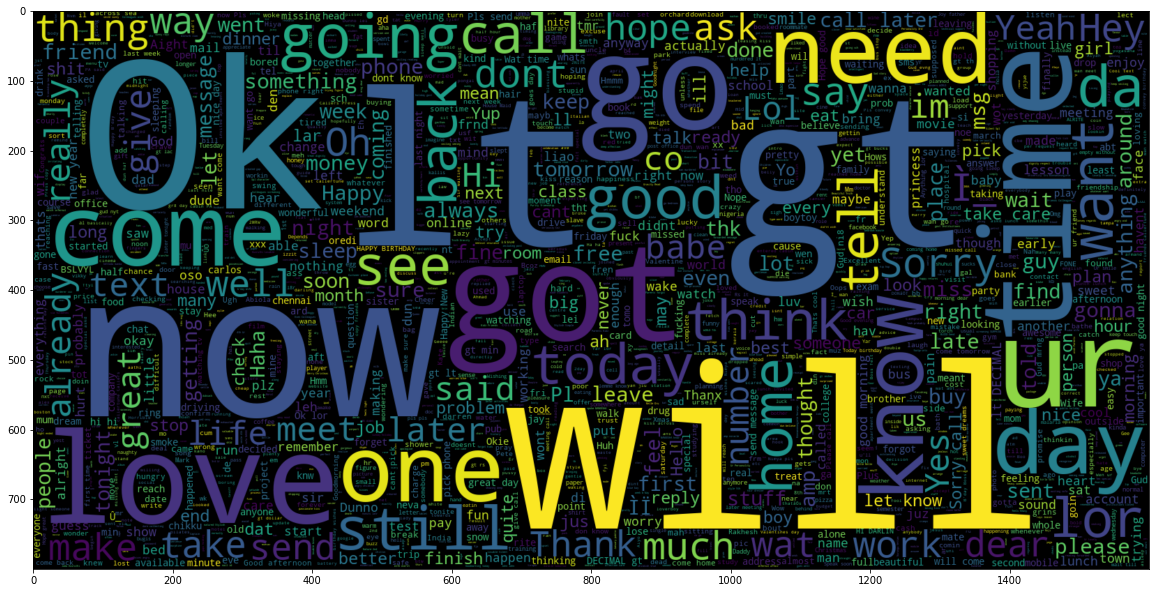

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is not Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sms_spam_data[sms_spam_data.y == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

#### Wordcloud for spam text

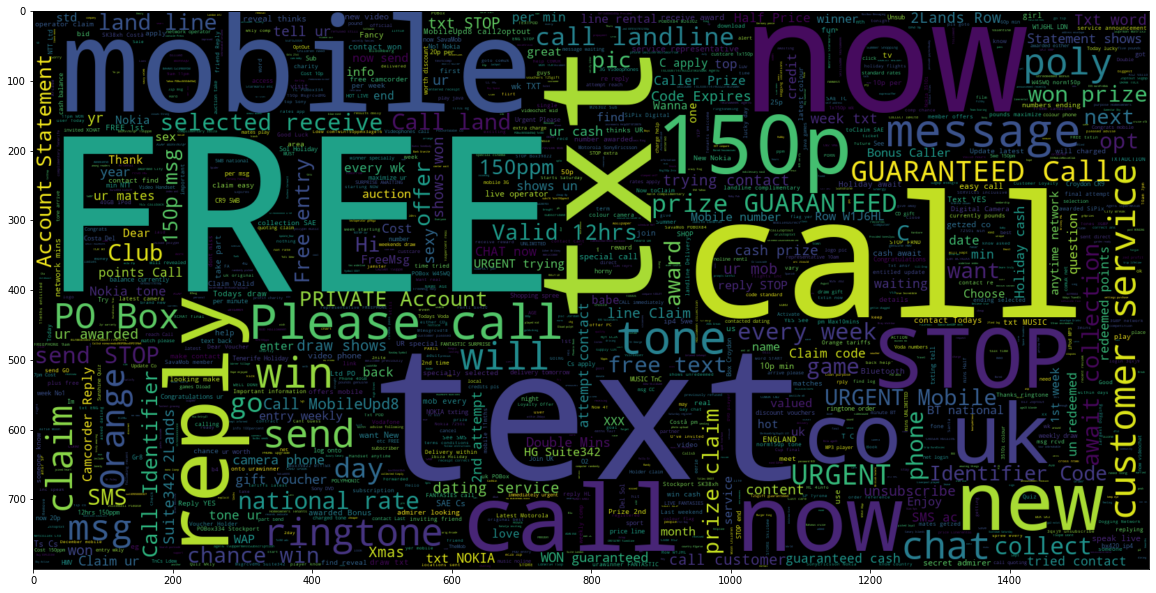

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sms_spam_data[sms_spam_data.y == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

### sms length analysis

In [54]:
sms_spam_data['clean_msg_length'] = sms_spam_data["clean_msg"].str.len()
sms_spam_data.head()

,y,text,clean_msg,clean_msg_length
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...",16
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",23
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",9
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, life, around, though]",7


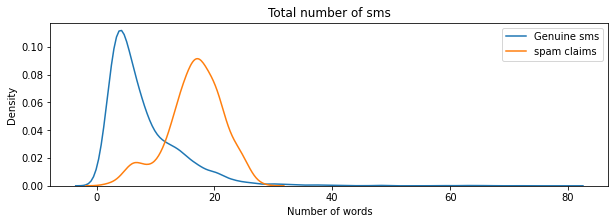

In [55]:
genuine_sms_length = sms_spam_data[sms_spam_data['y']==0]['clean_msg_length'].values
spam_sms_length = sms_spam_data[sms_spam_data['y']==1]['clean_msg_length'].values


plt.figure(figsize=(10,3))
sns.distplot(genuine_sms_length, hist=False, label="Genuine sms")
sns.distplot(spam_sms_length, hist=False, label="spam claims")
plt.title('Total number of sms')
plt.xlabel('Number of words')
plt.legend()
plt.show()

1. In the above plot, we are plotting pdf curve for genuine and spam SMS against the number of words
2. Lesser the number of words, higher the probability that it's a genuine SMS. More the number of words, higher the probability that its a spam


## Featurisation

In [56]:
# After tokenization it returns list but we need string so I converted it into string
sms_spam_data["clean_msg"] = sms_spam_data["clean_msg"].map(' '.join)

### Train - test split

In [57]:
Y = sms_spam_data['y']
X = sms_spam_data[['clean_msg', 'clean_msg_length']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state = 1)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4457, 2)
(1115, 2)
(4457,)
(1115,)


### Applying TF - IDF vectorizer for text feature

In [59]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer




In [60]:
#using the tfidf vectorizer
tf_idf = TfidfVectorizer(token_pattern = r"(?u)\b\w+\b")
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train['clean_msg'])
#applying tf idf to test data
X_test_tf = tf_idf.transform(X_test['clean_msg'])

#Dump the file
pickle.dump(tf_idf, open("tf_idf_vectorizer.pkl", "wb"))

In [61]:
clean_msg_features = tf_idf.get_feature_names()
#print(clean_msg_features)
X_train[clean_msg_features] = pd.DataFrame(X_train_tf.todense(), index=X_train.index)
X_test[clean_msg_features] = pd.DataFrame(X_test_tf.todense(), index=X_test.index)


In [62]:
print(X_train_tf.shape)
print(X_test_tf.shape)

(4457, 7849)
(1115, 7849)


### Applying min - max scaler on numerical feature

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train['clean_msg_length'].values.reshape(-1, 1))
X_train['nrm_clean_msg_length']=scaler.transform(X_train['clean_msg_length'].values.reshape(-1, 1))
X_test['nrm_clean_msg_length']=scaler.transform(X_test['clean_msg_length'].values.reshape(-1, 1))


#Dump the file
pickle.dump(scaler, open("scaler.pkl", "wb"))

In [64]:
print(X_train.shape)
print(X_test.shape)

(4457, 7852)
(1115, 7852)


### Features - Dropping unwanted columns

In [65]:
## Dropping all categorical columns after featurization

X_train_final = X_train.drop(['clean_msg', 'clean_msg_length'], axis = 1)
X_test_final = X_test.drop(['clean_msg', 'clean_msg_length'], axis = 1)


In [66]:
print(X_train_final.shape)
print(X_test_final.shape)

(4457, 7850)
(1115, 7850)


## Model construction

### Dummy Baseline model on all Features

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

baseline_clf = DummyClassifier(strategy = "uniform")
baseline_clf.fit(X_train_final, Y_train)
Y_pred = baseline_clf.predict(X_test_final)
print("F1 Score:", f1_score(Y_test, Y_pred))


F1 Score: 0.23342939481268013


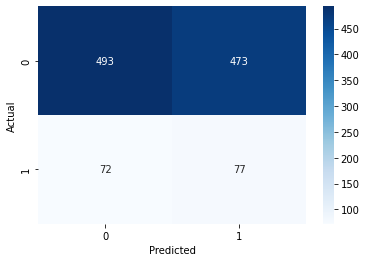

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
Y_pred = baseline_clf.predict(X_test_final)
cm = confusion_matrix(Y_test, Y_pred)
# print(cm)

sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Computing class *weights*

I observe that the classes are imbalanced so am going to compute class weights in order to balance them

In [69]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y_train), y = Y_train)
print(class_weights)
print(np.unique(Y_train, return_counts = True))
class_weight_dict = {i: cw for i, cw in enumerate(class_weights)}
print(class_weight_dict)



[0.57748121 3.72658863]
(array([0, 1]), array([3859,  598]))
{0: 0.577481212749417, 1: 3.7265886287625416}


Scoring parameter in Randomsearchcv generally takes accuracy as its measure but here we need f1score. So am manually optimising f1score for hyperparameter tuning 

### F1 score to optimise during hyperparameter tuning

In [71]:
from sklearn.metrics import f1_score

def f1Score(clf, X_val, y_true):   
     y_pred = clf.predict(X_val)
     return f1_score(y_true, y_pred)

### Naive Bayes Model

#### Hyperparameter tuning for Naive Bayes algorithm

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

clf = GaussianNB()

gs_NB = GridSearchCV(estimator = clf, 
                     param_grid = params_NB, 
                     cv = 3,
                     verbose = 1, 
                     scoring = f1Score)

gs_NB.fit(X_train_final, Y_train)
print(gs_NB.best_params_)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'var_smoothing': 0.2848035868435802}


In [ ]:
from tqdm import tqdm
sample_weights = []
for value in tqdm(Y_train):
    sample_weights.append(class_weight_dict[value])
print(sample_weights)


100%|██████████| 4457/4457 [00:00<00:00, 307396.54it/s]

[0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 3.7265886287625416, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.577481212749417, 0.57

In [ ]:
best_var_smoothing = gs_NB.best_params_['var_smoothing']


best_naive_bayes_model = GaussianNB(var_smoothing = best_var_smoothing)
best_naive_bayes_model.fit(X_train_final, Y_train, sample_weight = sample_weights)


GaussianNB(var_smoothing=0.2848035868435802)

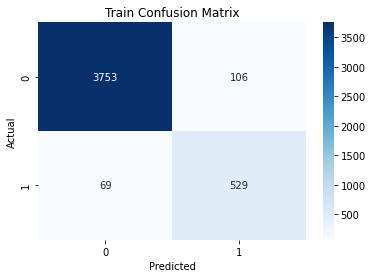

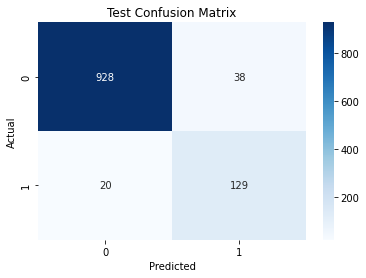

Train F1 Score =  0.8580697485806974
Test F1 Score =  0.8164556962025316


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
Y_train_pred = best_naive_bayes_model.predict(X_train_final)
Y_test_pred = best_naive_bayes_model.predict(X_test_final)

cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('Train F1 Score = ', f1_score(Y_train, Y_train_pred)) 
print('Test F1 Score = ', f1_score(Y_test, Y_test_pred))


### Logistic regression model

#### Hyperparameter tuning for Logistic regression 

In [ ]:
#Ref - https://www.geeksforgeeks.org/hyperparameter-tuning/
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

parameters = {'C': np.logspace(-5, 8, 15)}

lr = LogisticRegression(class_weight = class_weight_dict, random_state = 1)
clf = RandomizedSearchCV(lr, parameters, cv = 3, scoring = f1Score, random_state = 1)
clf.fit(X_train_final, Y_train)
print(clf.best_params_)

{'C': 11787686.347935867}


In [ ]:
best_C = clf.best_params_['C']


best_lr_model = LogisticRegression(C = best_C, class_weight = class_weight_dict, random_state = 1)
best_lr_model.fit(X_train_final, Y_train)


LogisticRegression(C=11787686.347935867,
                   class_weight={0: 0.577481212749417, 1: 3.7265886287625416},
                   random_state=1)

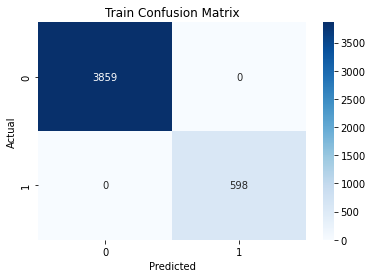

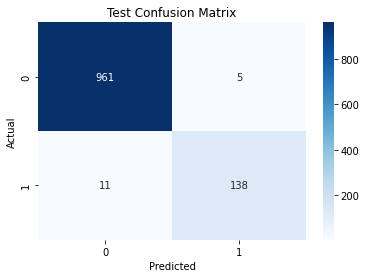

Train F1 Score =  1.0
Test F1 Score =  0.9452054794520547


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
Y_train_pred = best_lr_model.predict(X_train_final)
Y_test_pred = best_lr_model.predict(X_test_final)

cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('Train F1 Score = ', f1_score(Y_train, Y_train_pred)) 
print('Test F1 Score = ', f1_score(Y_test, Y_test_pred))



### Random Forest Model

#### Hyperparameter tuning for RandomForest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [100,200,500,1000,2000]
max_depth = [5, 10]

rf = RandomForestClassifier(class_weight = class_weight_dict, random_state = 1)
parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}
clf = RandomizedSearchCV(rf, parameters, cv = 3, scoring= f1Score, random_state = 1)
clf.fit(X_train_final, Y_train)

print(clf.best_params_)

{'n_estimators': 1000, 'max_depth': 10}


In [73]:
best_n_estimators = clf.best_params_['n_estimators']
best_max_depth = clf.best_params_['max_depth']


best_rf_model = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, class_weight = class_weight_dict,random_state = 1)
best_rf_model.fit(X_train_final, Y_train)

#Dump the file
pickle.dump(best_rf_model, open("best_rf_model.pkl", "wb"))


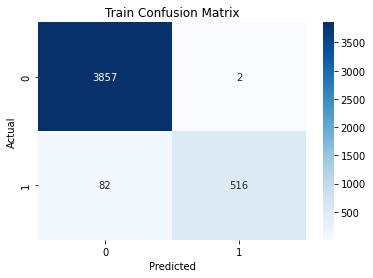

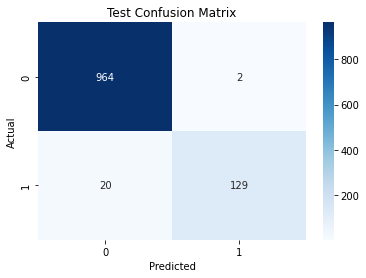

Train F1 Score =  0.9247311827956988
Test F1 Score =  0.9214285714285714


In [74]:
from sklearn.metrics import confusion_matrix, f1_score
Y_train_pred = best_rf_model.predict(X_train_final)
Y_test_pred = best_rf_model.predict(X_test_final)

cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('Train F1 Score = ', f1_score(Y_train, Y_train_pred)) 
print('Test F1 Score = ', f1_score(Y_test, Y_test_pred))



### Decision Tree Model

#### Hyperparameter tuning for Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {'min_samples_split':[5, 10, 100, 500], 'max_depth': [1, 5, 10, 50]}
dt = DecisionTreeClassifier(class_weight = class_weight_dict)
clf = RandomizedSearchCV(dt, parameters, cv = 3, scoring = f1Score, random_state = 1)
clf.fit(X_train_final, Y_train)

print(clf.best_params_)


{'min_samples_split': 10, 'max_depth': 50}


In [ ]:
best_min_samples_split = clf.best_params_['min_samples_split']
best_max_depth = clf.best_params_['max_depth']


best_dt_model = DecisionTreeClassifier(min_samples_split = best_min_samples_split, max_depth = best_max_depth, class_weight = class_weight_dict, random_state = 1)
best_dt_model.fit(X_train_final, Y_train)


DecisionTreeClassifier(class_weight={0: 0.577481212749417,
                                     1: 3.7265886287625416},
                       max_depth=50, min_samples_split=10, random_state=1)

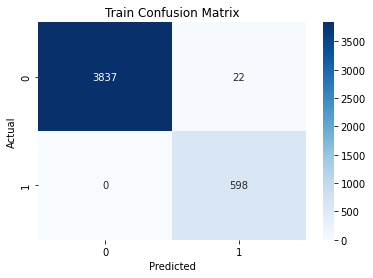

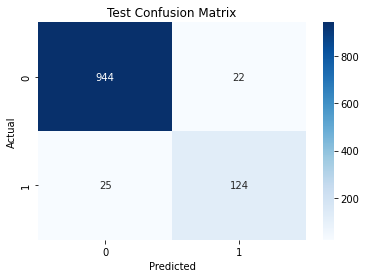

Train F1 Score =  0.9819376026272578
Test F1 Score =  0.840677966101695


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
Y_train_pred = best_dt_model.predict(X_train_final)
Y_test_pred = best_dt_model.predict(X_test_final)

cm = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('Train F1 Score = ', f1_score(Y_train, Y_train_pred)) 
print('Test F1 Score = ', f1_score(Y_test, Y_test_pred))




## Summary

In [75]:
from prettytable import PrettyTable 
summaryTable = PrettyTable(["Algorithm", "Train F1 Score", "Test F1 Score"]) 
  
# Add rows 
summaryTable.add_row(["Naive Bayes", "0.858", "0.816"])
summaryTable.add_row(["Logistic Regression", "1.0", "0.945"])
summaryTable.add_row(["Random Forest", "0.924", "0.921"])
summaryTable.add_row(["Decision Tree", "0.981", "0.840"])
print(summaryTable)

+---------------------+----------------+---------------+
|      Algorithm      | Train F1 Score | Test F1 Score |
+---------------------+----------------+---------------+
|     Naive Bayes     |     0.858      |     0.816     |
| Logistic Regression |      1.0       |     0.945     |
|    Random Forest    |     0.924      |     0.921     |
|    Decision Tree    |     0.981      |     0.840     |
+---------------------+----------------+---------------+




*   Implemented 4 algorithms - Naive Bayes, Logistic regression, Random Forest, Decision tree.
*   Since the data is imbalanced,algorithms are implemete with class weights.
*  Logistic regression and Decision tree algorithms led to over-fitting
* Naive bayes algorithm did reasonably well. 
* Random forest had a higher F1 Score. This is the most favorable model


